# Staggered Difference-in-Differences Tutorial

## A Complete Guide to Causal Effect Estimation Under Staggered Treatment Timing

This notebook demonstrates the **Callaway & Sant'Anna (2021)** style staggered DiD estimator implemented in this library.

### What You'll Learn
1. **Why Staggered DiD?** - Problems with traditional TWFE
2. **Core Outputs** - ATT(g,t), Overall ATT, Event Study
3. **Pre-trend Diagnostics** - Joint statistical tests
4. **Robustness Checks** - Stacked DiD comparison
5. **Validation** - Recovering known true effects

---


In [1]:
# Setup
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ Setup complete")


✓ Setup complete


## 1. The Problem: Why Traditional TWFE Fails with Staggered Adoption

In **staggered adoption** settings, units receive treatment at different times (cohorts). Traditional Two-Way Fixed Effects (TWFE) regression can produce **biased estimates** when:

- Treatment effects vary across cohorts
- Treatment effects change over time

This happens because TWFE implicitly uses **already-treated units as controls** for later-treated units, leading to "negative weights" and bias.

### Our Solution: ATT(g,t) Estimation

We implement **Callaway & Sant'Anna (2021)** style estimation:
1. Estimate treatment effects separately for each cohort (g) at each time (t)
2. Aggregate with proper weighting
3. Provide transparent diagnostics

---


## 2. Generate Sample Data with Known True Effects

We'll create realistic panel data where we **know the true treatment effect**, so we can validate the estimator recovers it correctly.


In [2]:
from sample_data import generate_sample_data

# True treatment effect we want to recover
TRUE_EFFECT = 15000

# Generate data
data = generate_sample_data(
    n_accounts=5000,              # Total units
    n_treatment_accounts=1000,     # ~10% treated
    treatment_effect=TRUE_EFFECT, # Known true effect
    noise_scale=3000,             # Realistic noise
    selection_mode='realistic',    # Balanced selection into treatment
    effect_pattern='growing',    # Constant effect over time
    random_state=42
)

df_panel = data['feature_store']
df_treatment = data['treatment_table']

print(f"Panel data shape: {df_panel.shape}")
print(f"Treatment records: {len(df_treatment)}")
print(f"True treatment effect: {TRUE_EFFECT:,}")


Panel data shape: (120000, 15)
Treatment records: 1000
True treatment effect: 15,000


In [3]:
# Examine the data
print("Panel data sample:")
display(df_panel.head())

print("\nTreatment data sample:")
display(df_treatment.head())


Panel data sample:


,cod_conta,num_ano_mes,val_cap_liq,auc,val_receita,vl_rentabilidade_liquida_mes,vl_rentabilidade_liquida_12m,tx_enquadramento,segmento,cod_tipo_pessoa,dsc_marca_conta,n_acessos_hub,potencial,ultima_nota_nps_ass,ativo
0,1,202301,252847.531783,260838.863158,730.978668,0.010787,0.093357,0.707934,Unique,J,MARCA XPI,15,379397.273815,1.0,1
1,1,202302,253540.250175,236980.497937,642.509865,0.009183,0.064647,0.926589,Unique,J,MARCA XPI,18,379397.273815,2.0,1
2,1,202303,250584.864571,235915.822276,686.508294,0.017389,0.212280,0.803566,Unique,J,MARCA XPI,16,379397.273815,3.0,1
3,1,202304,253624.626146,236087.237474,312.961103,0.023054,0.289652,0.896331,Unique,J,MARCA XPI,16,379397.273815,4.0,1
4,1,202305,260412.683676,259048.296042,484.799253,0.012250,0.094968,0.840308,Unique,J,MARCA XPI,18,379397.273815,5.0,1



Treatment data sample:


,cod_conta,treatment_date
0,4214,2024-03-01
1,358,2023-08-01
2,4216,2024-06-01
3,2261,2023-08-01
4,1761,2023-11-01


In [4]:
# Check treatment timing distribution (staggered adoption)
# Note: We'll use dashboard visualization after running the pipeline

cohorts = df_treatment['treatment_date'].dt.strftime('%Y-%m').value_counts().sort_index()
print(f"Number of treatment cohorts: {len(cohorts)}")
print(f"Treatment dates range: {df_treatment['treatment_date'].min()} to {df_treatment['treatment_date'].max()}")
display(cohorts)


Number of treatment cohorts: 12
Treatment dates range: 2023-07-01 00:00:00 to 2024-06-01 00:00:00


treatment_date
2023-07     81
2023-08     79
2023-09     93
2023-10     75
2023-11     76
2023-12     91
2024-01     91
2024-02     77
2024-03     84
2024-04     86
2024-05    103
2024-06     64
Name: count, dtype: int64

---

## 3. Simple API: One-Click Analysis

For business users, the library provides a **simple one-click API**:


In [5]:
from src import CausalPipeline

# Create analysis pipeline
analysis = CausalPipeline(
    panel_data=df_panel,
    treatment_data=df_treatment,
    outcome='val_cap_liq',          # Outcome variable
    time='num_ano_mes',              # Time column (YYYYMM format)
    id='cod_conta',                  # Unit ID
    use_feature_generator=True      # Use raw features for this demo
)

# Run the analysis
results = analysis.run(verbose=True)


STAGGERED CAUSAL INFERENCE ANALYSIS
(Callaway & Sant'Anna Style)

[1/5] Generating lagged features...
---------- Creating feature table ----------


---------- Feature table created: 120000 rows ----------
---------- Your features are: ['lag_auc', 'mean_6m_auc', 'mean_12m_auc', 'lag_val_receita', 'mean_6m_val_receita', 'mean_12m_val_receita', 'lag_vl_rentabilidade_liquida_mes', 'mean_6m_vl_rentabilidade_liquida_mes', 'mean_12m_vl_rentabilidade_liquida_mes', 'lag_vl_rentabilidade_liquida_12m', 'mean_6m_vl_rentabilidade_liquida_12m', 'mean_12m_vl_rentabilidade_liquida_12m', 'lag_tx_enquadramento', 'mean_6m_tx_enquadramento', 'mean_12m_tx_enquadramento', 'lag_n_acessos_hub', 'mean_6m_n_acessos_hub', 'mean_12m_n_acessos_hub', 'lag_potencial', 'mean_6m_potencial', 'mean_12m_potencial', 'lag_ultima_nota_nps_ass', 'mean_6m_ultima_nota_nps_ass', 'mean_12m_ultima_nota_nps_ass', 'lag_ativo', 'mean_6m_ativo', 'mean_12m_ativo'] ----------

[2/5] Running pipeline...
   Matched pairs: 988
[3/5] Running validation checks...
CAUSAL ANALYZER VALIDATION
  Treated units:     988
  Control units:     807
  Pre-treatment obs: 22884
  Post-treatment obs

### Quick Access to Key Results

The `CausalPipeline` provides a built-in dashboard for visualizations. Let's first visualize the treatment cohort distribution:


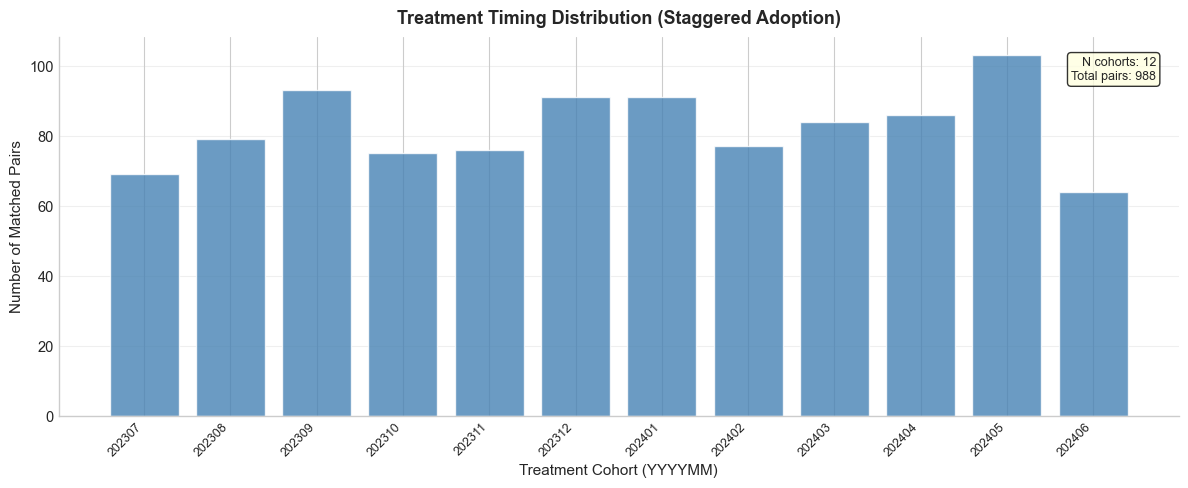

In [6]:
# Access the dashboard for visualizations
dashboard = analysis._dashboard

# Plot cohort distribution (staggered adoption pattern)
dashboard.plot_cohort_distribution()


In [7]:
# Main results using dashboard method
dashboard.print_main_results(true_effect=TRUE_EFFECT)


MAIN RESULTS: Overall Average Treatment Effect (ATT)
  Overall ATT:            13,592 ***
  Standard Error:          56.35
  95% CI:           [13,481, 13,702]
  p-value:                0.0000
  Effect (% base):         5.90%
-------------------------------------------------------
  N Matched Pairs:           988
  N Treated Units:           988
  N Control Units:           807
-------------------------------------------------------
  True Effect:            15,000
  Recovery Error:           9.4%


---

## 4. Core Output: ATT(g,t) Table

The **ATT(g,t) table** shows treatment effects for each cohort (g) at each event time (t). This is the core staggered DiD output that avoids TWFE bias.

**Key guarantee**: The overall ATT equals the weighted average of this table's post-treatment cells.


In [8]:
# The ATT(g,t) table
att_table = results['att_table']

print("ATT(g,t) Table: Treatment Effects by Cohort × Event Time")
print("="*60)
display(att_table.round(0))


ATT(g,t) Table: Treatment Effects by Cohort × Event Time


,e=-6,e=-5,e=-4,e=-3,e=-2,e=-1,e=0,e=+1,e=+2,e=+3,e=+4,e=+5,e=+6,e=+7,e=+8,e=+9,e=+10,e=+11,e=+12
cohort,,,,,,,,,,,,,,,,,,,
202307,1247.0,-234.0,318.0,107.0,226.0,0.0,5374.0,10138.0,15127.0,15630.0,15081.0,15488.0,15143.0,16021.0,15554.0,16187.0,15614.0,15730.0,15288.0
202308,819.0,224.0,316.0,448.0,1240.0,0.0,5635.0,10185.0,15770.0,15157.0,14411.0,15462.0,15168.0,15793.0,15521.0,16160.0,16419.0,15930.0,15673.0
202309,-770.0,-455.0,-46.0,-305.0,610.0,0.0,4203.0,9996.0,14872.0,14824.0,14795.0,15011.0,14963.0,14282.0,14411.0,15295.0,15624.0,15750.0,15669.0
202310,100.0,-485.0,-699.0,-679.0,-639.0,0.0,5201.0,9812.0,14863.0,15206.0,14622.0,14733.0,14732.0,15408.0,14926.0,13785.0,14938.0,13835.0,13951.0
202311,542.0,-1125.0,708.0,-703.0,-711.0,0.0,4032.0,9292.0,15534.0,14512.0,14177.0,14878.0,14465.0,15307.0,14932.0,15129.0,14469.0,14839.0,15241.0
202312,-4.0,271.0,-474.0,-853.0,427.0,0.0,4649.0,10271.0,14621.0,15504.0,15501.0,14877.0,14850.0,15304.0,15488.0,15392.0,14980.0,15016.0,14684.0
202401,-385.0,-1299.0,-874.0,-650.0,-380.0,0.0,5710.0,8944.0,14549.0,14898.0,14531.0,14434.0,14114.0,15575.0,15804.0,14715.0,14168.0,14565.0,NaN
202402,-1667.0,525.0,-1867.0,-146.0,-277.0,0.0,3988.0,9169.0,14733.0,13304.0,13629.0,13508.0,13179.0,14337.0,15222.0,13881.0,14387.0,NaN,NaN
202403,576.0,-179.0,-201.0,-439.0,-431.0,0.0,4629.0,9810.0,14424.0,15086.0,14598.0,14718.0,14531.0,14423.0,14141.0,14770.0,NaN,NaN,NaN


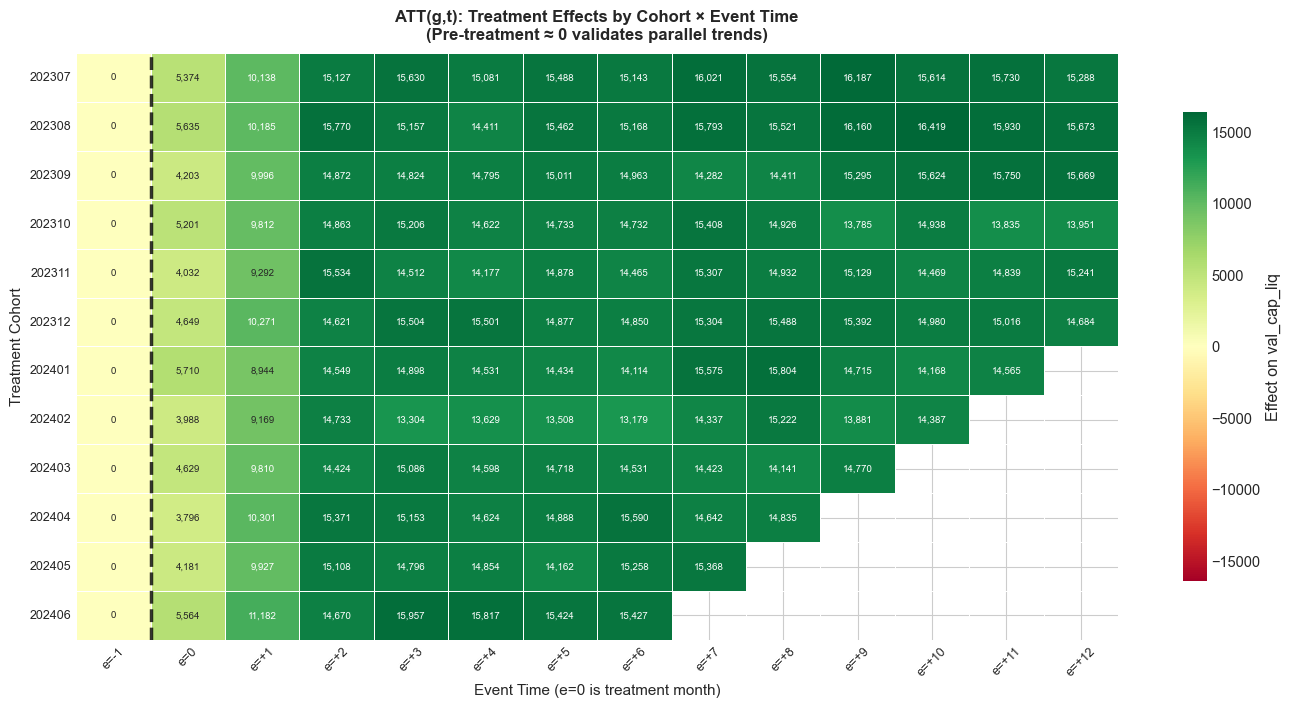

In [9]:
# Visualize ATT(g,t) as heatmap using dashboard
dashboard.plot_att_heatmap(pre_periods=0, post_periods=12)

---

## 5. Event Study: Dynamic Treatment Effects

The event study aggregates ATT(g,t) across cohorts to show how effects evolve over time. This is the **staggered-safe** version that avoids TWFE bias.


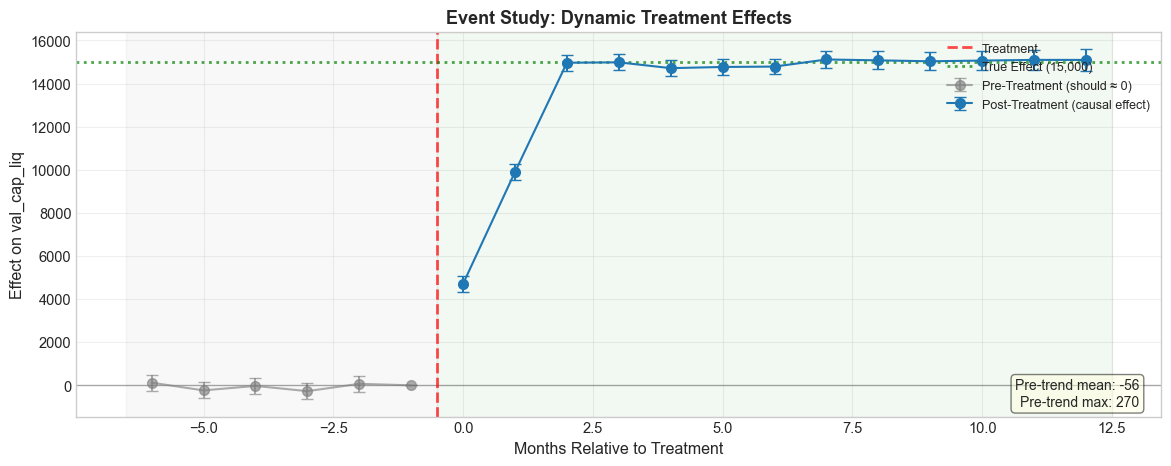

In [11]:
# Plot event study using dashboard (with true effect line for validation)
dashboard.plot_event_study(pre_periods=6, post_periods=12, true_effect=TRUE_EFFECT)


---

## 6. Pre-trend Diagnostics

Pre-treatment effects should be **statistically indistinguishable from zero**. We provide a **joint Wald test** on all lead coefficients.


In [19]:
# Pre-trend test results using dashboard method
dashboard.print_pretrend_test()


PRE-TREND TEST (Parallel Trends Diagnostic)
  Test Type:        Joint Wald test on lead coefficients
  Wald Statistic:           4.16
  Degrees of Freedom:          5
  p-value:                0.5270
-------------------------------------------------------
  Result:           ✓ PASS (p > 0.05)
-------------------------------------------------------
  Interpretation:
    We CANNOT reject H₀ that pre-treatment effects = 0.
    This supports the parallel trends assumption.


---

## 7. Cohort Effects: Heterogeneity Across Treatment Groups


COHORT EFFECTS: Treatment Effect Heterogeneity
  Number of Cohorts:             12
  Mean ATT:                  13,546
  Std ATT:                      523
  Min ATT:                   12,667
  Max ATT:                   14,406
  Significant (p<0.05):          12 / 12
-------------------------------------------------------
  True Effect:               15,000


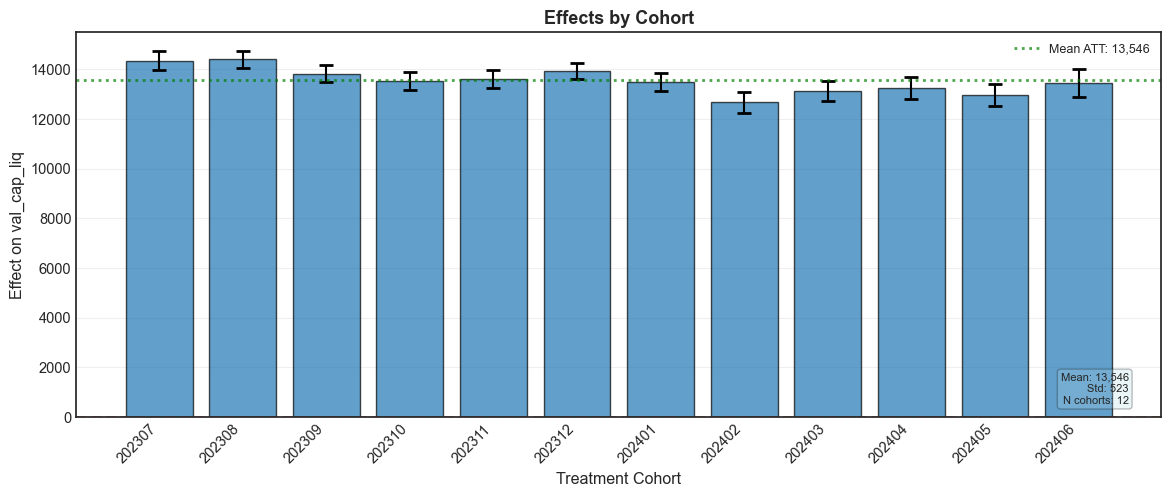

In [20]:
# Plot cohort effects using dashboard
dashboard.plot_cohort_effects()

# Show cohort summary statistics using dashboard method
dashboard.print_cohort_summary(true_effect=TRUE_EFFECT)


---

## 8. Robustness Check: Stacked DiD Comparison

We provide a **Stacked DiD** estimator as a robustness check. If primary and stacked estimates are similar, this increases confidence in the results.


In [14]:
# Robustness check using dashboard method
dashboard.print_robustness(pre_periods=6, post_periods=12, true_effect=TRUE_EFFECT)


ROBUSTNESS CHECK: Primary vs Stacked DiD
  Primary ATT:              13,592
  Stacked DiD ATT:          13,592
  Difference:                  0.0%
-------------------------------------------------------
  True Effect:              15,000
-------------------------------------------------------
  Result: ✓ PASS - Estimates are consistent (<20% difference)


---

## 9. Additional Diagnostics

### Balance Check (Love Plot)
The love plot shows Standardized Mean Differences (SMD) between treated and control groups. Good balance means |SMD| < 0.1.


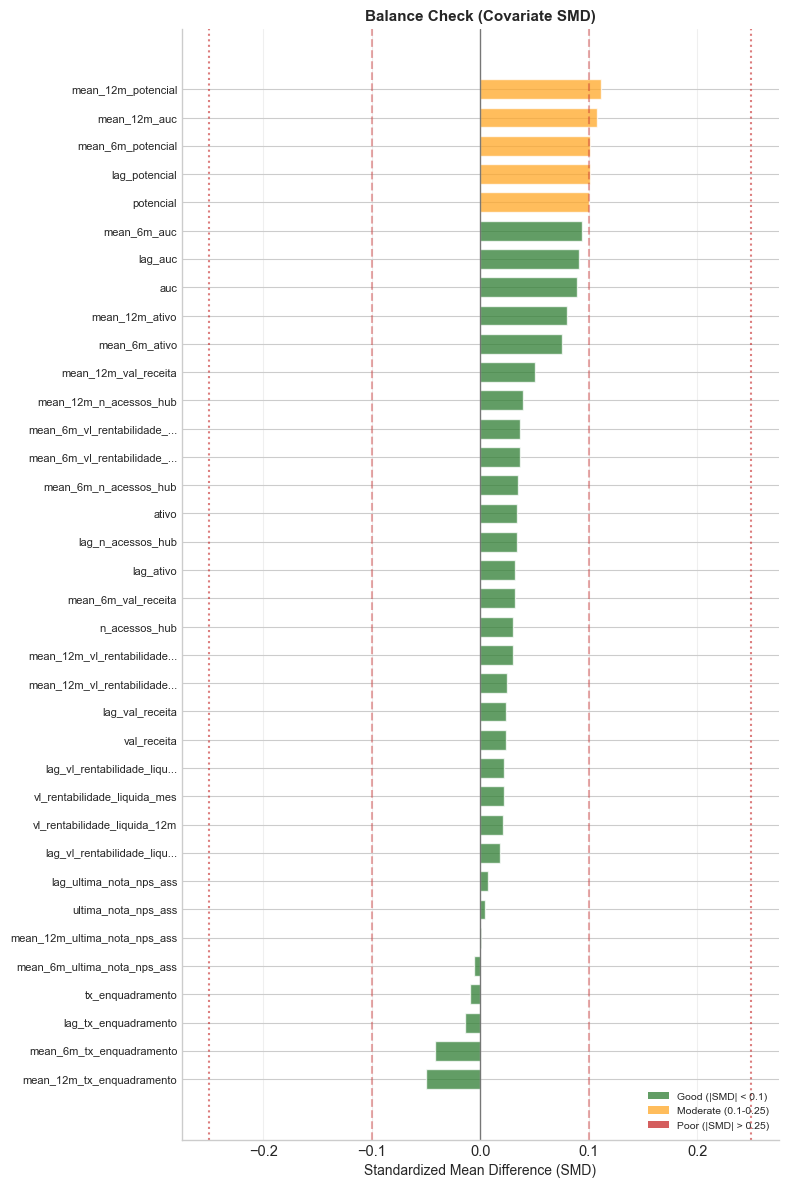

In [15]:
# Balance check (love plot) - improved for many features
dashboard.plot_love_plot(max_features=100)


### Parallel Trends Visualization
Visual inspection of pre-treatment trends for treated vs control groups:


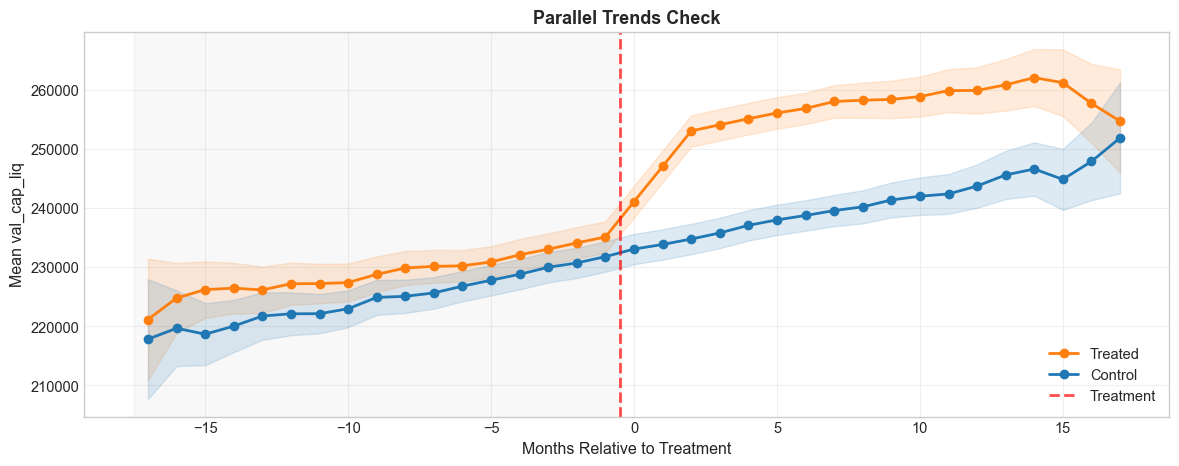

In [16]:
# Parallel trends visualization
dashboard.plot_parallel_trends()


---

## 10. Generate Full Report

For executive presentations, generate a comprehensive visual report with all diagnostics:


✓ Executive report saved to: staggered_analysis_report.png


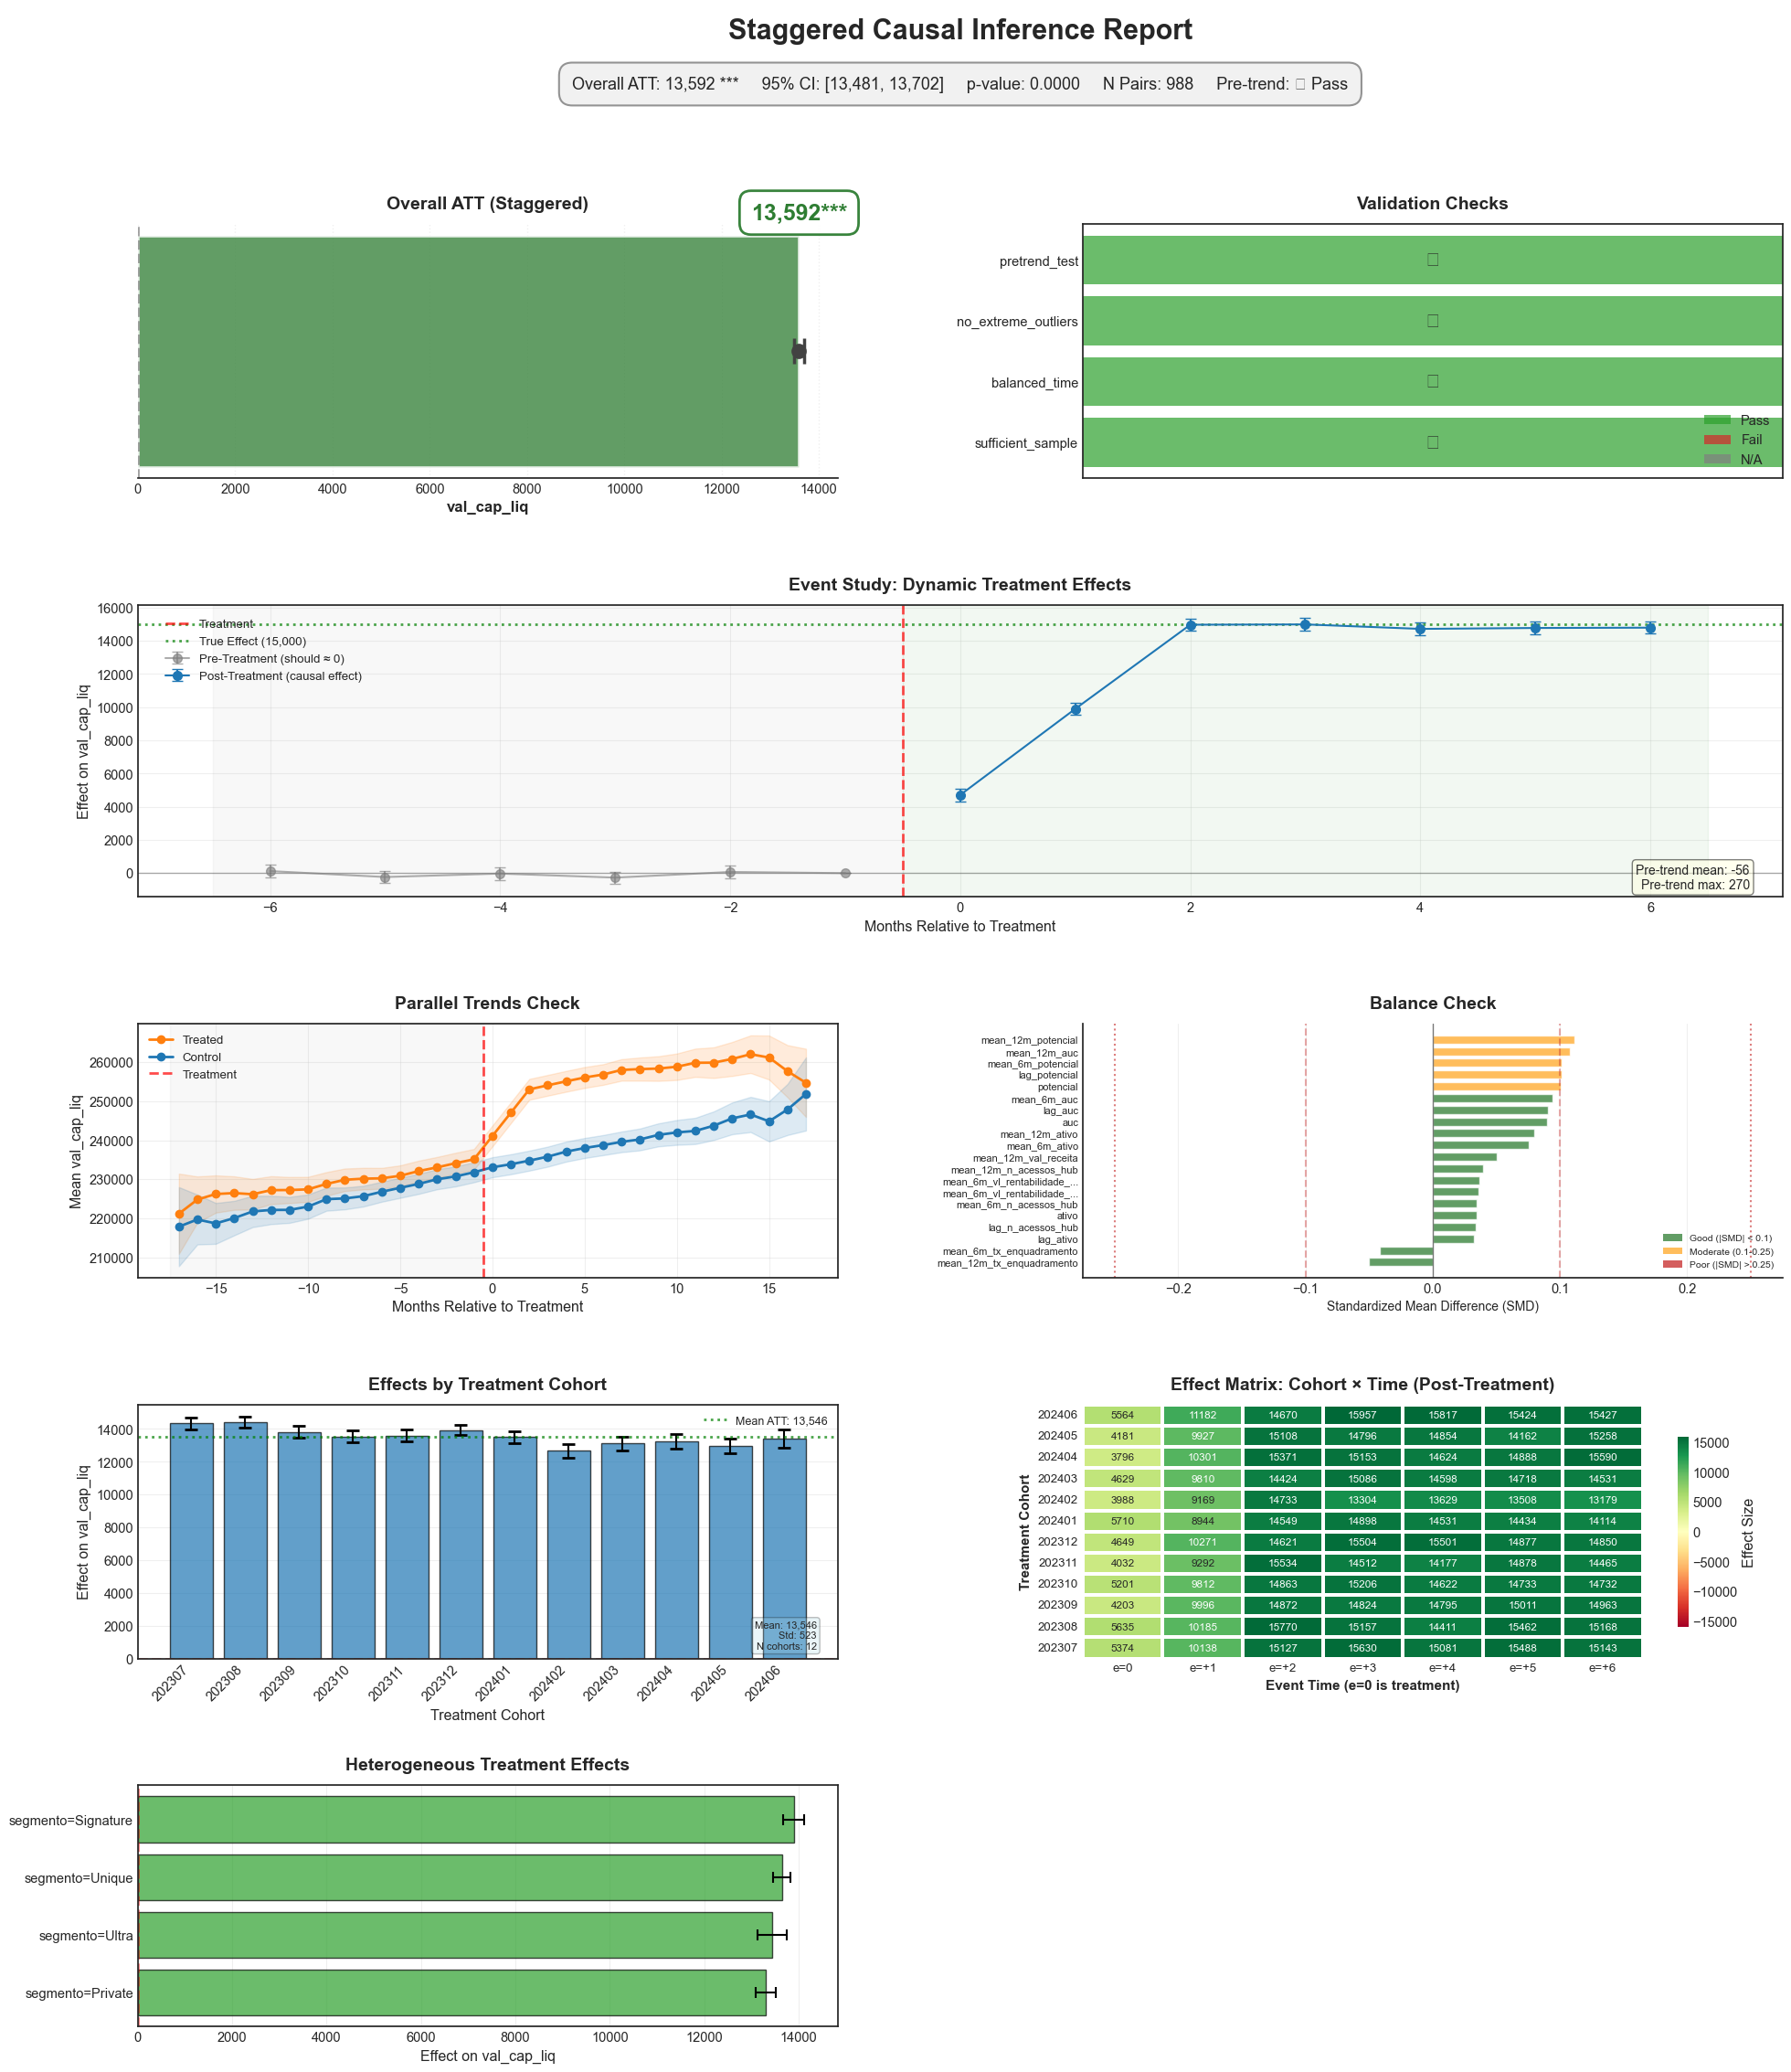

In [17]:
# Generate full executive report
analysis.report(
    save_path='staggered_analysis_report.png',
    true_effect=TRUE_EFFECT,
    heterogeneity_features=['segmento']
)


---

## 11. Summary Table


In [18]:
# Get summary table
summary = analysis.summary()
display(summary)


,Metric,Value
0,Overall ATT,"13,592"
1,95% CI Lower,"13,481"
2,95% CI Upper,"13,702"
3,p-value,0.0000
4,Effect as % of Baseline,5.90%
5,N Treated,988
6,N Control,807
7,N Pairs,988
8,N Cohorts,12
9,Pre-trend Test,PASS


---

## Summary: Key Takeaways

### What This Library Provides

1. **ATT(g,t) Estimation**: Treatment effects by cohort × event time
2. **Proper Aggregation**: Overall ATT with correct weighting (reconciles with table)
3. **Staggered-Safe Event Study**: Avoids TWFE bias under heterogeneity
4. **Pre-trend Diagnostics**: Joint statistical tests (not just visual inspection)
5. **Robustness Checks**: Stacked DiD comparison

### Simple API for Business Users

```python
from src import CausalPipeline

analysis = CausalPipeline(
    panel_data=df,
    treatment_data=df_treat,
    outcome='revenue'
)

results = analysis.run()

# Key outputs
print(analysis.att)              # Overall ATT
print(analysis.pretrend_passed)  # Pre-trend diagnostic
print(results['att_table'])      # Cohort × time effects

# Generate report
analysis.report(save_path='report.png')
```

### References

- **Callaway & Sant'Anna (2021)**: Difference-in-differences with multiple time periods
- **Sun & Abraham (2021)**: Estimating dynamic treatment effects in event studies
- **Roth et al.**: Pre-testing for parallel trends in difference-in-differences
